In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import sys
import datetime as dt
sys.path.append("../")
from model import SarimaModel
import get_fish_price

In [7]:
df_hamachi = pd.read_csv(r'../data/hamachi_price.csv', encoding='utf_8_sig')
df_hamachi["date"] = df_hamachi["date"].apply(lambda x: pd.to_datetime(str(x)))

today = dt.date.today()
year = today.year
month = today.month

# ハマチの卸売数量のデータを更新
if df_hamachi['date'].max().date() < today:
    start_date = df_hamachi['date'].max().date() + dt.timedelta(days=1)
    temp_df = get_fish_price.get_fish_price_data(start_date=start_date, end_date=today)
    temp_df["date"] = temp_df["date"].apply(lambda x: pd.to_datetime(str(x)))
    df_hamachi = pd.concat([df_hamachi, temp_df])
    df_hamachi.to_csv(r'../data/hamachi_price2.csv', encoding='utf_8_sig', index=False)

df_hamachi["month"] = df_hamachi["date"].dt.month
df_hamachi["year"] = df_hamachi["date"].dt.year
#小売物価統計の最新の行を取得
df_hamachi_latest = df_hamachi.tail(1)

#小売物価統計調査データ
df_FEH = pd.read_csv("../data/FEH_buri.csv")
df_FEH["時間軸（月）"] = pd.to_datetime(df_FEH["時間軸（月）"], format='%Y年%m月')
df_FEH["year"] = df_FEH["時間軸（月）"].dt.year
df_FEH["month"] = df_FEH["時間軸（月）"].dt.month
df_FEH = df_FEH.sort_values(by=["year", "month"], ascending=False)
#小売物価統計の最新の行を取得
df_FEH_latest = df_FEH.head(1)
#ハマチの卸売数量のデータの最新月は、何カ月差か計算
delta = abs(df_hamachi_latest["year"].iloc[0] - df_FEH_latest["year"].iloc[0])*12\
        + abs(df_hamachi_latest["month"].iloc[0] - df_FEH_latest["month"].iloc[0])

#東京都中央卸売市場　休業日データ
df_calender = pd.read_csv("../data/toyosu_calender_2023.csv")
df_calender["date"] = pd.to_datetime(df_calender["date"])
df_calender["week_day"] = df_calender["date"].apply(lambda x: x.weekday())

#ハマチの卸売数量のデータと小売物価統計調査データをマージ
df_hamachi = pd.merge(left=df_hamachi, right=df_FEH[["year", "month", "value"]], on=["year", "month"],
        how="left")
#直近、小売物価統計調査データが入っていない箇所を最新の値で埋める
for i in range(delta-1, -1, -1):
    print(i)
    if month-i>0:
        df_hamachi.loc[(df_hamachi["year"]==year) & (df_hamachi["month"]==month-i),
           "value"
          ] = df_FEH_latest["value"].at[0]
    elif (month-i>-12)and (month-i<=0):
        df_hamachi.loc[(df_hamachi["year"]==year-1 & (df_hamachi["month"]==month-i+12)),
           "value"
          ] = df_FEH_latest["value"].at[0] 
    else:
        raise ValueError("小売物価統計調査データを更新してください")
df_hamachi = df_hamachi.set_index(df_hamachi["date"])
train = df_hamachi[["quantity", "value"]]
train.dropna(subset = ["value"], inplace=True)

20230327: 100%|██████████| 11/11 [00:05<00:00,  1.94it/s]


1
0


/var/folders/3q/40y_c73d30ndpj0wrsh_pts00000gn/T/ipykernel_9785/2639658167.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(subset = ["value"], inplace=True)


In [9]:
sarima = SarimaModel(train=train, df_calender=df_calender, exog="value")

In [10]:
sarima_fit = sarima.fit()

/Users/estyle-074/opt/anaconda3/envs/sub1/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/estyle-074/opt/anaconda3/envs/sub1/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08969D+01    |proj g|=  7.35336D-02

At iterate    5    f=  1.08053D+01    |proj g|=  4.19363D-03

At iterate   10    f=  1.08045D+01    |proj g|=  1.92586D-03

At iterate   15    f=  1.08041D+01    |proj g|=  1.12754D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     22      1     0     0   2.972D-05   1.080D+01
  F =   10.804142602405426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [11]:
test_pred = sarima.predict(sarima_fit)

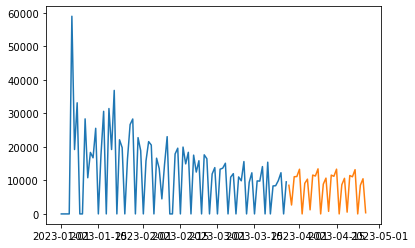

In [13]:
plt.plot(df_hamachi.loc["2023"]["quantity"])
plt.plot(test_pred)
plt.show()